In [1]:
import pandas as pd

train = pd.read_csv('hgt.csv')
train.info()

FileNotFoundError: File b'hgt.csv' does not exist

In [ ]:
import pandas as pd

y = [1,2,3]
y_pre1 = pd.DataFrame(y)
y_pre = pd.DataFrame({"label": y})
print(y_pre)
print(y_pre1)

In [ ]:
fit_params = {"eval_metric": "rmse"}
print(fit_params)

输入数据类型： (66, 498)
标签类型： (66,)


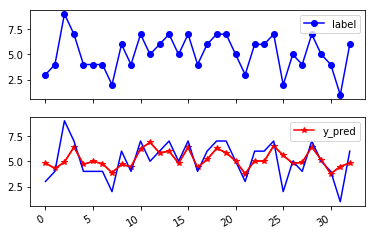

saving model
训练结果 0.3592999072586678


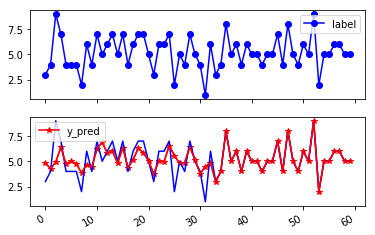

测试结果： 0.5930739058259492


In [17]:
import pandas as pd
import numpy as np
from sklearn import metrics
import pickle
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import StandardScaler
#from clean_data import prep_water_data,normalize_water_data,normalize_data,delete_null_date
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


def GDBTTrain(X, y):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.5, random_state=0)  ##test_size测试集合所占比例
    test_preds = pd.DataFrame({"label": test_y})
    clf = XGBRegressor(
        learning_rate=0.2,  # 默认0.3
        n_estimators=500,  # 树的个数
        max_depth=16,
    )
    clf.fit(train_x, train_y)
    test_preds['y_pred'] = clf.predict(test_x)
    stdm = metrics.r2_score(test_preds['label'], test_preds['y_pred'])
    
    import matplotlib.pyplot as plt  # 画出预测结果图
    p = test_preds[['label', 'y_pred']].plot(subplots=True, style=['b-o', 'r-*'])
    plt.plot(test_preds['label'], c = 'blue')
    plt.plot(test_preds['y_pred'], c ='red')
    plt.show()

    return stdm, clf

def GDBTest(X, y, clf):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.9, random_state=0)  ##test_size测试集合所占比例
    test_preds = pd.DataFrame({"label": test_y})
    #clf.fit(train_x, train_y)
    test_preds['y_pred'] = clf.predict(test_x)
    stdm = metrics.r2_score(test_preds['label'], test_preds['y_pred'])
    
    import matplotlib.pyplot as plt  # 画出预测结果图
    p = test_preds[['label', 'y_pred']].plot(subplots=True, style=['b-o', 'r-*'])
    plt.plot(test_preds['label'], c = 'blue')
    plt.plot(test_preds['y_pred'], c ='red')
    plt.show()
    return stdm

def XGTSearch(X, y):
    print("Parameter optimization")
    n_estimators = [50, 100, 200, 400]
    max_depth = [2, 4, 6, 8]
    learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
    param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)
    xgb_model = XGBRegressor()
    kfold = TimeSeriesSplit(n_splits=2).get_n_splits([X,y])
    fit_params = {"eval_metric": "rmse"}
    grid_search = GridSearchCV(xgb_model, param_grid, verbose=1, fit_params=fit_params, cv=kfold)
    grid_result = grid_search.fit(X, y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    
    return means, grid_result

#data = pd.read_csv('X_U4.csv')

Y_list_1 = []
if __name__ == "__main__":
    X_data = pd.read_csv('X_noyear.csv', encoding="gb18030")
    Y_data = pd.read_csv('Y_noyear.csv', encoding="gb18030")
    Y_data = Y_data['times']
    out = 'frazee'
    print("输入数据类型：" ,X_data.shape)
    print("标签类型：" ,Y_data.shape)
    X = X_data.as_matrix()
    y = Y_data.as_matrix()
    stdm, clf = GDBTTrain(X, y)
    print('saving model')
    path = './model/' + out + '_xgb.pkl'
    with open(path, "wb") as f:
        pickle.dump(clf, f)
    print("训练结果",stdm)
    
    path = './model/' + out + '_xgb.pkl'
    with open(path, 'rb') as f:
        model = pickle.load(f)
        stdm = GDBTest(X, y, model)
        print("测试结果：",stdm)
